### Causal identification in DAGs using Backdoor and Swigs, Equivalence Classes, Falsiability Tests



In [548]:
#import Pkg; Pkg.add("StructuralCausalModels")
#import Pkg; Pkg.add("TikzGraphs")
#import Pkg; Pkg.add("TikzPictures")
#import Pkg; Pkg.add("GraphViz")
#import Pkg; Pkg.add("Dagitty")
#import Pkg; Pkg.add("GraphPlot")

#using StructuralCausalModels
#using TikzGraphs
#using TikzPictures
#using Dagitty, Test 
#using LightGraphs, GraphPlot
#import Pkg; Pkg.add("lav_parse_model_string")


(process:14252): GLib-GIO-WARNING **: 15:18:20.947: Unexpectedly, UWP app `Evernote.Evernote_10.32.4.0_x86__q4d96b2w5wcc2' (AUMId `Evernote.Evernote_q4d96b2w5wcc2!Evernote') supports 1 extensions but has no verbs


In [549]:
using StructuralCausalModels
using GraphRecipes, Plots
using Random

### Graph Generation and Plotting

The following DAG is due to Judea Pearl

In [288]:
G = "dag {Z1 -> {X1}; X1 -> {D}; Z1 -> {X2}; Z2 -> X3; X3 -> {Y}; Z2 -> {X2}; D -> {Y}
                ; X2 -> {Y}; X2 -> {D}; M -> {Y}; D -> {M}}"

G = DAG("Model_1", G);

to_ggm(G) |> display

show(G) # Variable's location in an array 

"DAG(M ~ D, Y ~ M + X2 + D + X3, D ~ X2 + X1, X2 ~ Z2 + Z1, X3 ~ Z2, X1 ~ Z1)"

OrderedDict{Union{Symbol, Vector{Symbol}}, Union{Symbol, Vector{Symbol}}} with 6 entries:
  [:M]  => :D
  [:Y]  => [:M, :X2, :D, :X3]
  [:D]  => [:X2, :X1]
  [:X2] => [:Z2, :Z1]
  :X3   => :Z2
  [:X1] => :Z1


DAG object:

name = "Model_1"
vars = [:M, :D, :Y, :X2, :X3, :X1, :Z2, :Z1]




In [289]:
# variables's name into two arrays

names(G.e)

2-element Vector{Vector{Symbol}}:
 [:M, :D, :Y, :X2, :X3, :X1, :Z2, :Z1]
 [:M, :D, :Y, :X2, :X3, :X1, :Z2, :Z1]

In [290]:
# DAG to matrix
G.e

# colums : affected varaible 
# rows : covariables 

8×8 Named Matrix{Int64}
Rows ╲ Cols │  :M   :D   :Y  :X2  :X3  :X1  :Z2  :Z1
────────────┼───────────────────────────────────────
:M          │   0    0    1    0    0    0    0    0
:D          │   1    0    1    0    0    0    0    0
:Y          │   0    0    0    0    0    0    0    0
:X2         │   0    1    1    0    0    0    0    0
:X3         │   0    0    1    0    0    0    0    0
:X1         │   0    1    0    0    0    0    0    0
:Z2         │   0    0    0    1    1    0    0    0
:Z1         │   0    0    0    1    0    1    0    0

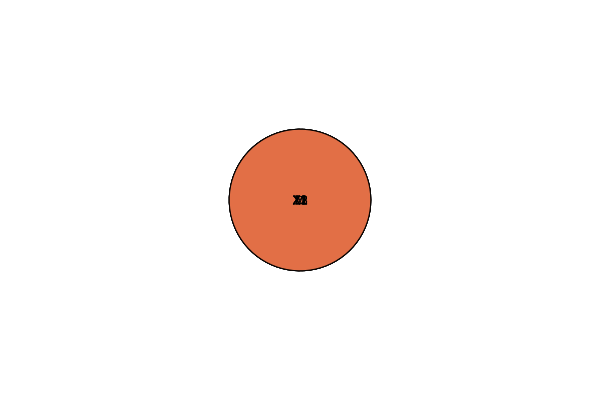

In [291]:
# First: all varibles in (0,0) coordinates

graphplot(G.e, names=names(G.e, 1), curvature_scalar=0, nodesize=0.2,
  method=:spring, fontsize=8, arrow=1, nodeshape=:circle, nodecolor = 2, dim = 2, x = [0,0,0,0,0,0,0,0], y = [0,0,0,0,0,0,0,0])

# curvature_scalar: size point
# arrow : arrow size
# fontsize: circle's size
# (x, y) location 

In [292]:
names(G.e,1)

8-element Vector{Symbol}:
 :M
 :D
 :Y
 :X2
 :X3
 :X1
 :Z2
 :Z1

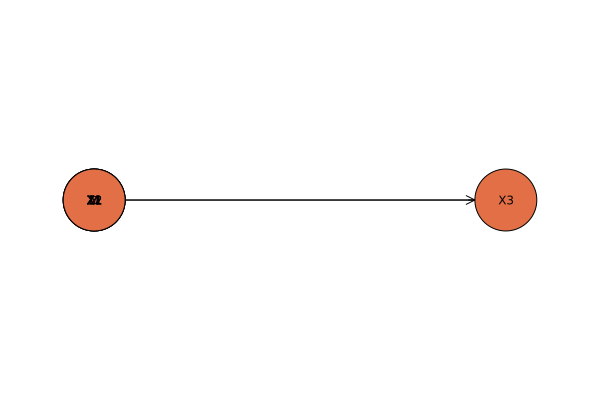

In [293]:
# X3 in (1,0) coordinates
graphplot(G.e, names=names(G.e, 1), curvature_scalar=0, nodesize=0.2,
  method=:spring, fontsize=8, arrow=1, nodeshape=:circle, nodecolor = 2, dim = 2, x = [0,0,0,0,1,0,0,0], y = [0,0,0,0,0,0,0,0])


In [294]:
names(G.e,1)

8-element Vector{Symbol}:
 :M
 :D
 :Y
 :X2
 :X3
 :X1
 :Z2
 :Z1

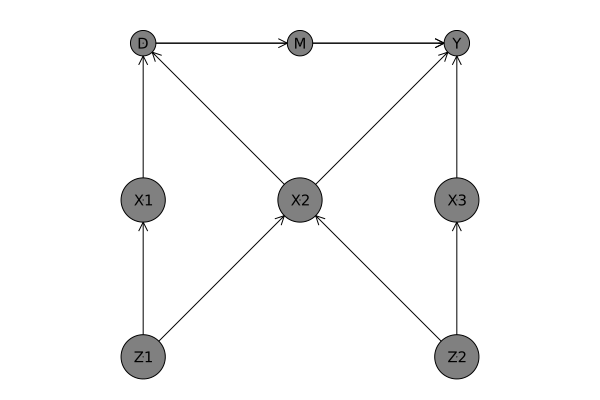

In [295]:
# more details
# edgecolor: arrow's color
# axis_buffer: graph's size

graphplot(G.e, names=names(G.e, 1), curvature_scalar=0, nodesize=0.3,
      method=:spring, fontsize=10, arrow=0.2, nodeshape=:circle, nodecolor = :gray,axis_buffer = 0.1
        ,edgecolor = :black, x = [0,-1,1,0,1,-1,1,-1], y = [1,1,1,0,0,0,-1,-1], nodestrokecolor = :black)


In [461]:
G.e

# rows : childer
# columns: parents 

8×8 Named Matrix{Int64}
Rows ╲ Cols │  :M   :D   :Y  :X2  :X3  :X1  :Z2  :Z1
────────────┼───────────────────────────────────────
:M          │   0    0    1    0    0    0    0    0
:D          │   1    0    1    0    0    0    0    0
:Y          │   0    0    0    0    0    0    0    0
:X2         │   0    1    1    0    0    0    0    0
:X3         │   0    0    1    0    0    0    0    0
:X1         │   0    1    0    0    0    0    0    0
:Z2         │   0    0    0    1    1    0    0    0
:Z1         │   0    0    0    1    0    1    0    0

### Report Relative of X2

In [503]:

#Parents function

function parents(DAG,x)
    M = DAG.e
    n = size(M)[1]
    v =[]
        for i in 1:n
            B = convert(Int64, M[i,x] == 1)
        if B == 1
           push!(v, names(M,1)[i])
        end
        end
return v
end
 
# Children function

function children(DAG,x)
    M = DAG.e
    n = size(M)[1]
    v =[]
        for i in 1:n
           B = convert(Int64, M[x,i] == 1)
        if B == 1
            push!(v, names(M,1)[i])
        end
        end
return v
end

# Ancentors function

function ancestors(DAG,x)
    CC =[]
    A =  parents(DAG,x)
    push!(CC, [A,x])
    for i in 1:size(A)[1]
        push!(CC, parents(DAG,A[i]))
    end
return CC
end 


# descendants function

function descendants(DAG,x)
    CC =[]
    A =  children(DAG,x)
    push!(CC, [A,x])
    for i in 1:size(A)[1]
        push!(CC, children(DAG,A[i]))
    end
return CC
end 


#Details 

#Declare variables at the beginning makes them as global variables

descendants (generic function with 1 method)

In [504]:
parents(G,:X2)

2-element Vector{Any}:
 :Z2
 :Z1

In [505]:
ancestors(G,:X2)

3-element Vector{Any}:
 Any[Any[:Z2, :Z1], :X2]
 Any[]
 Any[]

In [506]:
children(G,:D)

2-element Vector{Any}:
 :M
 :Y

In [507]:
descendants(G,:X2)

3-element Vector{Any}:
 Any[Any[:D, :Y], :X2]
 Any[:M, :Y]
 Any[]

### Find Paths Between D and Y

In [12]:
pths = all_paths(G, :D, :Y)
#pths |> display

5-element Vector{Vector{Symbol}}:
 [:D, :M, :Y]
 [:D, :X1, :Z1, :X2, :Y]
 [:D, :X1, :Z1, :X2, :Z2, :X3, :Y]
 [:D, :X2, :Y]
 [:D, :X2, :Z2, :X3, :Y]

### List All Testable Implications of the Model¶

In [13]:
#Conditional independency between two varaibles given conditioned set of variables

CInd = basis_set(G)
display(CInd)

BasisSet[
  :D ∐ :X3 | [:Z2]
  :D ∐ :X3 | [:X2, :X1]
  :D ∐ :X3 | [:X2, :Z2]
  :D ∐ :X3 | [:X1, :Z2]
  :D ∐ :X3 | [:X2, :X1, :Z2]
  :D ∐ :Z2 | [:X2, :X1]
  :D ∐ :Z1 | [:X2, :X1]
  :M ∐ :X2 | [:D]
  :M ∐ :X2 | [:Z2, :D]
  :M ∐ :X2 | [:Z1, :D]
  :M ∐ :X2 | [:Z2, :Z1, :D]
  :M ∐ :X3 | [:D]
  :M ∐ :X3 | [:Z2]
  :M ∐ :X3 | [:D, :Z2]
  :M ∐ :X1 | [:D]
  :M ∐ :X1 | [:Z1, :D]
  :M ∐ :Z2 | [:D]
  :M ∐ :Z1 | [:D]
  :X1 ∐ :Z2
  :X1 ∐ :Z2 | [:Z1]
  :X2 ∐ :X3 | [:Z2]
  :X2 ∐ :X3 | [:Z2, :Z1]
  :X2 ∐ :X1 | [:Z1]
  :X2 ∐ :X1 | [:Z2, :Z1]
  :X3 ∐ :X1
  :X3 ∐ :X1 | [:Z1]
  :X3 ∐ :X1 | [:Z2]
  :X3 ∐ :X1 | [:Z1, :Z2]
  :X3 ∐ :Z1
  :X3 ∐ :Z1 | [:Z2]
  :Y ∐ :X1 | [:Z1, :X2, :D]
  :Y ∐ :X1 | [:X2, :D, :X3]
  :Y ∐ :X1 | [:Z1, :X2, :D, :M]
  :Y ∐ :X1 | [:Z1, :X2, :D, :X3]
  :Y ∐ :X1 | [:X2, :D, :M, :X3]
  :Y ∐ :X1 | [:Z1, :X2, :D, :M, :X3]
  :Y ∐ :Z2 | [:X2, :D, :X3]
  :Y ∐ :Z2 | [:X2, :D, :M, :X3]
  :Y ∐ :Z1 | [:X2, :D, :X3]
  :Y ∐ :Z1 | [:X2, :D, :M, :X3]
  :Z2 ∐ :Z1
]


### Identification by Backdoor: List minimal adjustment sets to identify causal effects 

$$ D \rightarrow Y$$

In [16]:
pths = all_paths(G, :D, :Y)

5-element Vector{Vector{Symbol}}:
 [:D, :M, :Y]
 [:D, :X1, :Z1, :X2, :Y]
 [:D, :X1, :Z1, :X2, :Z2, :X3, :Y]
 [:D, :X2, :Y]
 [:D, :X2, :Z2, :X3, :Y]

In [14]:
bp = backdoor_paths(G, pths, :D)

4-element Vector{Vector{Symbol}}:
 [:D, :X1, :Z1, :X2, :Y]
 [:D, :X1, :Z1, :X2, :Z2, :X3, :Y]
 [:D, :X2, :Y]
 [:D, :X2, :Z2, :X3, :Y]

In [15]:
adjustmentsets = adjustment_sets(G, :D, :Y)

4-element Vector{Vector{Symbol}}:
 [:X1, :X2]
 [:Z1, :X2]
 [:X2, :Z2]
 [:X2, :X3]

In [158]:
e = d_separation(G, :D, :Y)
println("d_separation($(G.name), D, Y) = $e\n")

d_separation(Model_1, D, Y) = false



### Identification via SWIG and D-separation

In [508]:
SWIG = "dag {Z1 -> {X1}; X1 -> {D}; Z1 -> {X2}; Z2 -> X3; X3 -> {Yd}; Z2 -> {X2}; X2 -> {Yd} 
        ; X2 -> {D}; Md -> {Yd}; d -> {Md}}"

SWIG = DAG("Model_2", SWIG)

OrderedDict{Union{Symbol, Vector{Symbol}}, Union{Symbol, Vector{Symbol}}} with 6 entries:
  [:Md] => :d
  [:Yd] => [:Md, :X2, :X3]
  [:D]  => [:X2, :X1]
  [:X2] => [:Z2, :Z1]
  :X3   => :Z2
  [:X1] => :Z1

name = "Model_2"
vars = [:Md, :d, :Yd, :X2, :X3, :D, :X1, :Z2, :Z1]



DAG object:





In [509]:
names(SWIG.e,1)

9-element Vector{Symbol}:
 :Md
 :d
 :Yd
 :X2
 :X3
 :D
 :X1
 :Z2
 :Z1

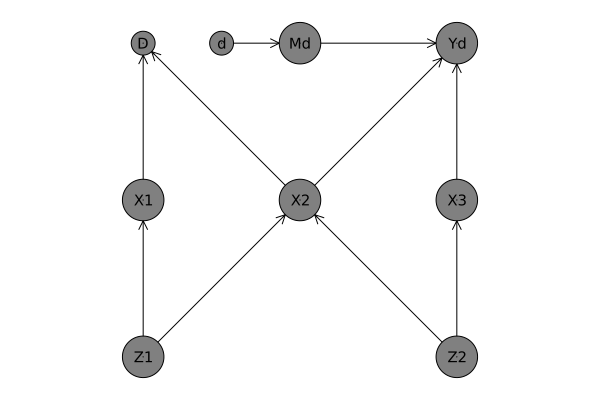

In [510]:
graphplot(SWIG.e, names=names(SWIG.e, 1), curvature_scalar=0, nodesize=0.3,
      method=:spring, fontsize=10, arrow=0.2, nodeshape=:circle, nodecolor = :gray,axis_buffer = 0.1
        ,edgecolor = :black, x = [0,-0.5,1,0,1,-1,-1,1,-1], y = [1,1,1,0,0,1,0,-1,-1], nodestrokecolor = :black)


In [511]:
#Conditional independency between two varaibles given conditioned set of variables

CInd = basis_set(SWIG)
#length(CInd)

BasisSet[
  :D ∐ :Z2 | [:X2, :X1]
  :D ∐ :Z1 | [:X2, :X1]
  :Md ∐ :X2
  :Md ∐ :X2 | [:d]
  :Md ∐ :X2 | [:Z2]
  :Md ∐ :X2 | [:Z1]
  :Md ∐ :X2 | [:d, :Z2]
  :Md ∐ :X2 | [:d, :Z1]
  :Md ∐ :X2 | [:Z2, :Z1]
  :Md ∐ :X2 | [:d, :Z2, :Z1]
  :Md ∐ :X3
  :Md ∐ :X3 | [:d]
  :Md ∐ :X3 | [:Z2]
  :Md ∐ :X3 | [:d, :Z2]
  :Md ∐ :D
  :Md ∐ :D | [:d]
  :Md ∐ :D | [:X2]
  :Md ∐ :D | [:X1]
  :Md ∐ :D | [:d, :X2]
  :Md ∐ :D | [:d, :X1]
  :Md ∐ :D | [:X2, :X1]
  :Md ∐ :D | [:d, :X2, :X1]
  :Md ∐ :X1
  :Md ∐ :X1 | [:d]
  :Md ∐ :X1 | [:Z1]
  :Md ∐ :X1 | [:d, :Z1]
  :Md ∐ :Z2
  :Md ∐ :Z2 | [:d]
  :Md ∐ :Z1
  :Md ∐ :Z1 | [:d]
  :X1 ∐ :Z2
  :X1 ∐ :Z2 | [:Z1]
  :X2 ∐ :X3 | [:Z2]
  :X2 ∐ :X3 | [:Z2, :Z1]
  :X2 ∐ :X1 | [:Z1]
  :X2 ∐ :X1 | [:Z2, :Z1]
  :X3 ∐ :D | [:Z2]
  :X3 ∐ :D | [:Z2, :X2]
  :X3 ∐ :D | [:Z2, :X1]
  :X3 ∐ :D | [:X2, :X1]
  :X3 ∐ :D | [:Z2, :X2, :X1]
  :X3 ∐ :X1
  :X3 ∐ :X1 | [:Z2]
  :X3 ∐ :X1 | [:Z1]
  :X3 ∐ :X1 | [:Z2, :Z1]
  :X3 ∐ :Z1
  :X3 ∐ :Z1 | [:Z2]
  :Yd ∐ :D | [:X2, :X3]
  :Yd ∐ :D | [:X2

### Print All Average Effects Identifiable by Conditioning

In [536]:

function conditioning_iden(DAG)
n = size(names(DAG.e,1),1)

    for i in 1:n
        a1 = names(DAG.e,1)[i]
        a2 = children(DAG, a1)
        for j in 1:size(a2,1)  
            a3 = adjustment_sets(DAG, a1, a2[j])
            if size(a3)[1] > 0
                println("The effect:", a1, " -> ", a2[j],"  is identifiable by controlling for : " , a3)

            end
        end
    end

end

conditioning_iden (generic function with 1 method)

In [539]:
conditioning_iden(G)

The effect:M -> Y  is identifiable by controlling for : [[:D]]
The effect:D -> M  is identifiable by controlling for : [[:X1], [:Z1], [:X2], [:Z2], [:X3]]
The effect:D -> Y  is identifiable by controlling for : [[:X1, :X2], [:Z1, :X2], [:X2, :Z2], [:X2, :X3]]
The effect:X2 -> D  is identifiable by controlling for : [[:Z1], [:X1]]
The effect:X2 -> Y  is identifiable by controlling for : [[:Z1, :Z2], [:Z1, :X3], [:X1, :Z2], [:X1, :X3], [:D, :Z2], [:D, :X3]]
The effect:X3 -> Y  is identifiable by controlling for : [[:Z2], [:X2, :D], [:X2, :Z1], [:X2, :X1]]
The effect:X1 -> D  is identifiable by controlling for : [[:Z1], [:X2]]


### Next Consider the elemntary Triangular Model:

$$ D \rightarrow Y, X \rightarrow (D,Y) $$

#### This model has not testable implications and is Markov-equivalent to any other DAG difined on names $ (X,D,Y) $

In [540]:
G3 = "dag {D -> {Y}; X -> {D}; X -> {Y}}"

G3 = DAG("Model_3", G3)

OrderedDict{Union{Symbol, Vector{Symbol}}, Union{Symbol, Vector{Symbol}}} with 2 entries:
  [:Y] => [:X, :D]
  [:D] => :X

name = "Model_3"
vars = [:Y, :X, :D]



DAG object:





In [541]:
names(G3.e,1)

3-element Vector{Symbol}:
 :Y
 :X
 :D

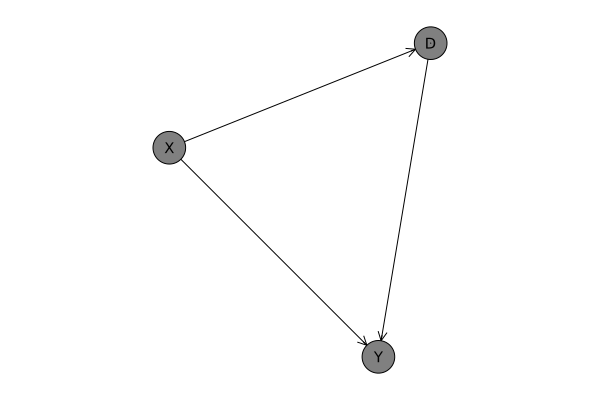

In [542]:
graphplot(G3.e, names=names(G3.e, 1), curvature_scalar=0, nodesize=0.3,
      method=:spring, fontsize=10, arrow=0.2, nodeshape=:circle, nodecolor = :gray,axis_buffer = 0.1
        ,edgecolor = :black, x = [0,-2,0.5], y = [-1,1,2], nodestrokecolor = :black)


In [543]:
#Conditional Independencies
CInd = basis_set(G3) # nothing


BasisSet[
]


In [216]:
bp1 = backdoor_paths(G3, all_paths(G3, :D, :Y), :D) # controling X (confounder varaible)

1-element Vector{Vector{Symbol}}:
 [:D, :X, :Y]

In [544]:
conditioning_iden(G3)

The effect:D -> Y  is identifiable by controlling for : [[:X]]


### Example of Testing DAG Validity

In [564]:
Random.seed!(1)

TaskLocalRNG()

In [585]:
to_ggm(G)

"DAG(M ~ D, Y ~ M + X2 + D + X3, D ~ X2 + X1, X2 ~ Z2 + Z1, X3 ~ Z2, X1 ~ Z1)"